# Movie Review Classification Using State-of-the-art NLP Model BERT 

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

## First: Installing and importing our pre-requisite libraries

1. __transformers__: This library is used to utilize the state-of-the-art NLP model BERT
2. __pandas__: This utility library is used to manipulate data efficiently and effectively
3. __tqdm__: This library is used to track the progress of any ongoing iterable process
4. __nltk__: This library is used to pre-process data before giving them to the NLP model
5. __torch__: Pytorch library, used to create and manage neural networks

To install pytorch on a CUDA-capable machine, run this command in the terminal:
```bash
pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
```

In [ ]:
%pip install transformers
%pip install pandas
%pip install tqdm
%pip install nltk
%pip install sklearn

In [1]:
from transformers import BertTokenizer
from transformers import BertModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import torch
from torch import nn
from torch.optim import Adam
# import splitfolders
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import os
import glob



## Text Pre-Processing

First, we pre-process our dataset to prepare it for training our model effectively.

### Splitting the folders

In [ ]:
splitfolders.ratio("data/balanced", output="data/splits", seed=2022, ratio=(.7, .1, .2), group_prefix=None, move=False)

### Cleaning strings in text files

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
path="data/processed/train/pos"
def lemmatize(path):
    files = glob.glob(path)
    df = pd.DataFrame(columns=['text', 'class'])
    for file in files:
        with open(file,encoding="utf8") as f:
            text = f.read()
            text = text.lower()
            text = text.translate(str.maketrans('', '', string.punctuation))
            text = text.split()
            text = [lemmatizer.lemmatize(word) for word in text if not word in stop_words]
            text = ' '.join(text)
            df = df.append({'text': text, 'class': "+"}, ignore_index=True)
    return df

df = lemmatize(path + "/*.txt")
df.to_csv(path + "/pos_labled.csv", index=False)

### combining processed csvs

In [ ]:
df1 = pd.read_csv("data/processed/test/test-neg.csv")
df2 = pd.read_csv("data/processed/test/test-pos.csv")
df = pd.concat([df1, df2], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv("data/processed/test/test.csv", index=False)

### merging data split files


In [ ]:

path="data/splits/val/neg"
def collect(path):
    files = glob.glob(path)
    df = pd.DataFrame(columns=['text', 'class'])
    for file in files:
        with open(file,encoding="utf8") as f:
            text = f.read()
            df = df.append({'text': text, 'class': "-"}, ignore_index=True)
    return df
df = collect(path + "/*.txt")
df.to_csv(path + "/val-neg.csv", index=False)

### combining unprocessed csvs

In [ ]:
df1 = pd.read_csv("data/splits/val/val-neg.csv")
df2 = pd.read_csv("data/splits/val/val-pos.csv")
df = pd.concat([df1, df2], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv("data/splits/val/val.csv", index=False)

## Reading from the CSVs

Now we need to read our processed and unprocessed CSVs into corresponding dataframes using pandas.

The reason we read in unprocessed data as well is, we are going to train once with processed and another with unprocessed data and check to see the difference in model competence

In [2]:
# Read-in the processed data
df_train_proc = pd.read_csv("/kaggle/input/imdb-dataset/train.csv")
df_val_proc = pd.read_csv("/kaggle/input/imdb-dataset/val.csv")
df_test_proc = pd.read_csv("/kaggle/input/imdb-dataset/test.csv")

# Read-in the unprocessed data
df_train_raw = pd.read_csv("/kaggle/input/imdb-dataset/s-train.csv")
df_val_raw = pd.read_csv("/kaggle/input/imdb-dataset/s-val.csv")
df_test_raw = pd.read_csv("/kaggle/input/imdb-dataset/s-test.csv")

## Creating classes we're going to work with

### Identify global variables we're going to work with

- _tokenizer_: BertTokenizer object used to convert text into tokens for BERT to work with
- _label_ids_: Dictionary for each label with a corresponding numeric ID

In [3]:
# Run yabny

tokenizer = BertTokenizer.from_pretrained( 'bert-base-cased' )
label_ids = {'-' : 0, '+' : 1}

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### First: Dataset class to hold our data

This class will contain lists of processed model-ready data. Note that processing here is different from text pre-processing we've done earlier. This one relates to tokenization and label IDing.

In [4]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels = [label_ids[verdict] for verdict in df['class']]
        self.texts = [tokenizer(text, padding='max_length', max_length = 512, truncation=True, 
                                    return_tensors="pt") for text in tqdm( iterable=df['text'], desc='Tokenizing' )]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    # Fetch a batch of labels
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    # Fetch a batch of inputs
    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

### Second: NeuralNetwork class to hold our model

#### <u>Description of our neural network</u>:
- The network's input layer takes in 768 inputs corresponding to the vector provided by BERT's pooled output (classification output)
- Our network consists of 4 hidden layers with 512, 256, 128, 64 units respectively.
- The output layer gives sigmoid function to classify the input vector

#### <u>Structure of every layer</u>:
Every layer in our neural network consists of three sublayers. Here they are in order:
1. __Dropout Layer__: This layer zeros out some parameters passing through it by a given probability. This is useful for avoiding overfitting. Said probability is given through the 'dropout_probability' argument in the constructor.
2. __Linear Layer__: This layer contains all of our main computation neurons which give us linear functions for fitting the model.
3. __Activation Layer__: This layer is responsible for applying activation function and converting the linear outputs into non-linear, cascadable outputs.

In [5]:
class NeuralNetwork(nn.Module):

    def __init__(self, dropout_probability=0.4, use_dropout=True):
        super(NeuralNetwork, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.use_dropout = use_dropout
        self.network = []

        # Input Layer to Hidden layer 1
        self.dropout1 = nn.Dropout( 0.0 )
        self.linear1 = nn.Linear( in_features=768, out_features=512 )
        self.relu1 = nn.ReLU( self.linear1 )
        self.network.append( [self.dropout1, self.linear1, self.relu1] ) 

        # Hidden layer 1 to Hidden layer 2
        self.dropout2 = nn.Dropout( dropout_probability )
        self.linear2 = nn.Linear( in_features=512, out_features=256 )
        self.relu2 = nn.ReLU( self.linear2 )
        self.network.append( [self.dropout2, self.linear2, self.relu2] )
        
        # Hidden layer 2 to Hidden layer 3
        self.dropout3 = nn.Dropout( dropout_probability )
        self.linear3 = nn.Linear( in_features=256, out_features=128 )
        self.relu3 = nn.ReLU( self.linear3 )
        self.network.append( [self.dropout3, self.linear3, self.relu3] )

        # Hidden layer 3 to Hidden layer 4
        self.dropout4 = nn.Dropout( dropout_probability )
        self.linear4 = nn.Linear( in_features=128, out_features=64 )
        self.relu4 = nn.ReLU( self.linear4 )
        self.network.append( [self.dropout4, self.linear4, self.relu4] )

        # Hidden Layer 4 to Output
        self.dropout5 = nn.Dropout( dropout_probability )
        self.linear5 = nn.Linear( in_features=64, out_features=1 )
        self.output = nn.Sigmoid()
        self.network.append( [self.dropout5, self.linear5, self.output] )


    def forward(self, input_id, mask):

        DROPOUT_LAYER, LINEAR_LAYER, ACTIVATION_LAYER = 0, 1, 2

        _, pooled_output = self.bert( input_ids= input_id, attention_mask=mask, return_dict=False )

        layer_input = pooled_output
        for layer in self.network:
            # Dropout
            dropout_output = layer[ DROPOUT_LAYER ]( layer_input ) \
                             if self.use_dropout else layer_input
            
            # Linear Computation
            linear_output = layer[ LINEAR_LAYER ]( dropout_output )

            # Activation
            layer_input = layer[ ACTIVATION_LAYER ]( linear_output )
        
        final_layer = layer_input

        return final_layer

## Model Training, Validation & Testing

Now, we:
- Use the validation dataset to tune hyperparameters twice (for model using raw data and model using pre-processed data)
- Write the function that will train our model using the training dataset
- Write the function that will evaluate our model using the test dataset

### Model Initialization

In [ ]:
# This model uses pre-processed data
neural_network_model_proc = NeuralNetwork(dropout_probability=0.3)

# This model uses raw data
neural_network_model_raw = NeuralNetwork(dropout_probability=0.3)

### Some functions to improve readability

In [15]:
SAVE_LOAD_DESTINATION = '/kaggle/working/'

In [21]:
def propagate_forwards( model, input, label, device="cpu" ):
    label = label.to(device)
    mask = input['attention_mask'].to(device)
    input_id = input['input_ids'].squeeze(1).to(device)

    model_output = model(input_id, mask)

    return model_output.squeeze(1), label.float()

def apply_cuda( model, loss_fn ):
    return model.cuda(), loss_fn.cuda()

def save_checkpoint( model, optimizer, epoch_num, learning_rate, epoch_scores, model_name ):

    checkpoint_path =   SAVE_LOAD_DESTINATION + \
                        model_name + ' lr_' + str(learning_rate) + '_' + \
                        ' epoch_' + str(epoch_num) + '_' + '.pt'

    model_checkpoint = {'model_state':model.state_dict(), 
                    'optim_state':optimizer.state_dict(), 
                    'n_epoch':epoch_num, 'lr':learning_rate,
                    'epoch_scores':epoch_scores}

    torch.save( model_checkpoint, checkpoint_path )

def load_checkpoint( model, epoch_num, learning_rate, model_name, optimizer=None ):

    checkpoint_path = SAVE_LOAD_DESTINATION + \
                        model_name + ' lr_' + str(learning_rate) + '_' + \
                        ' epoch_' + str(epoch_num) + '_' + '.pt'

    checkpoint = torch.load( checkpoint_path )

    model.load_state_dict( checkpoint['model_state'] )
    if optimizer is not None:
        optimizer.load_state_dict( checkpoint['optim_state'] )
    epoch_scores = checkpoint['epoch_scores']

    return model, optimizer, epoch_scores

    

### Hyperparamter Tuning
We use validation data to find the values for our hyperparamters to give us the best model possible.

__The hyperparameters we will tune are:__
1. Adam Optimizer learning rate
2. Number of epochs (In the actual training)

#### First, we tune the Adam Optimizer's learning rate

In [14]:
def tune_lr(model, train_dataloader, val_dataloader, learning_rate, n_epochs, 
            model_name, start_epoch=1, checkpoint=None):

    loss_function = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model.cuda()
        loss_function.cuda()

    if checkpoint is not None:
        model, optimizer, epoch_scores = load_checkpoint(
            model=model, optimizer=optimizer, epoch_num=checkpoint['epoch_num'],
            learning_rate=checkpoint['lr'], model_name=model_name)

    train_acc = val_acc = 0

    for epoch_num in range( start_epoch, n_epochs+1 ):

        num_correct = num_samples = 0

        for train_input, train_label in tqdm(iterable=train_dataloader, desc='Tuning LR'):
        
            # Forward Propagation
            output, label = propagate_forwards(model=model, input=train_input, label=train_label, device=device)
            batch_loss = loss_function(output, label)

            # Backward Propagation
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

            predictions = (output > 0.5).long().cpu()
            num_correct += (predictions == label.cpu()).sum()
            num_samples += predictions.size(0)

        train_acc = num_correct / num_samples

        with torch.no_grad():
            
            num_correct = num_samples = 0

            for val_input, val_label in tqdm(iterable=val_dataloader, desc='Assessing'):

                # Forward Propagation
                output, label = propagate_forwards(model=model, input=val_input, label=val_label, device=device)
                
                predictions = (output > 0.5).long().cpu()
                num_correct += (predictions == label.cpu()).sum()
                num_samples += predictions.size(0)

        val_acc = num_correct / num_samples

        print(f'\nTuning epoch complete. | Training accuracy = {train_acc: .3f} | Validation accuracy = {val_acc: .3f}')
        print('Saving model checkpoint to disk...')
        save_checkpoint( model=model, optimizer=optimizer, epoch_num=epoch_num,
                        learning_rate=learning_rate, epoch_scores=[], model_name=model_name )

    print(f'\x1b[32mAll done :) [LR = {learning_rate}]\x1b[0m')
    
    return train_acc, val_acc

We will tune with an arbitrary number of epochs for now. (Using pre-processed data)

In [ ]:
train, val = Dataset(df_train_proc), Dataset(df_val_proc)
# train, = val = Dataset(df_val_proc)
N_EPOCHS = 7
LR_VALUES = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
BATCH_SIZE = 16
lr_scores = []
load = None

In [ ]:
lr_scores = torch.load(SAVE_LOAD_DESTINATION + '/lr_scores')
load = { # Manually change the values of this dict to load a certain file
        'epoch_num':1,
        'lr': LR_VALUES[len(lr_scores)]
        }

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE)

idx = len(lr_scores)

for idx in range( len(LR_VALUES) ):
    LR = LR_VALUES[idx]
    neural_network_model_proc = NeuralNetwork(use_dropout=False)
    train_acc, val_acc = tune_lr(model=neural_network_model_proc,
                                train_dataloader=train_dataloader, 
                                val_dataloader=val_dataloader, 
                                learning_rate=LR, n_epochs=N_EPOCHS,
                                model_name="tune_lr_proc",
                                start_epoch=1,
                                checkpoint=load
                                )
    load = None
    
    print(f'\n\x1b[33m(At LR = {LR}, {N_EPOCHS} epochs) : \
    Training Accuracy = {train_acc: .3f} | \
    Validation Accuracy = {val_acc: .3f}\n\x1b[0m\n')
    
    lr_scores.append( val_acc )
    
    torch.save(lr_scores, SAVE_LOAD_DESTINATION + '/lr_scores')

plt.plot( LR_VALUES, lr_scores )
plt.show()

(Using raw data)

In [ ]:
train, val = Dataset(df_train_raw), Dataset(df_val_raw)
train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

lr_scores = []

for LR in LR_VALUES:
    neural_network_model_raw = NeuralNetwork(use_dropout=False)
    train_acc, val_acc = tune_lr(model=neural_network_model_raw,
                                train_dataloader=train_dataloader, 
                                val_dataloader=val_dataloader, 
                                learning_rate=LR, n_epochs=N_EPOCHS,
                                model_name="tune_lr_raw",
                                start_epoch=1,
                                checkpoint=load
                                )
    load = None


    print(f'\n\x1b[33m(At LR = {LR}, {N_EPOCHS} epochs) : \
    Training Accuracy = {train_acc: .3f} | \
    Validation Accuracy = {val_acc: .3f}\n\x1b[0m\n')

    lr_scores.append( val_acc )

    torch.save(lr_scores, SAVE_LOAD_DESTINATION + '/lr_scores')

plt.plot( LR_VALUES, lr_scores )
plt.show()

#### Tuning the number of epochs will take place during the actual training

### Training the model using the training data

In [ ]:
def train(model, train_data, val_data, learning_rate, n_epochs, model_name):

    loss_function = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()
        loss_function = loss_function.cuda()

    print('\n------------------------------------')
    print('Accelerator Name: ' + str(device))
    print('Learning Rate   : ' + str(learning_rate))
    print('No. of Epochs   : ' + str(n_epochs))
    print('------------------------------------', flush=True)

    train, val = Dataset(train_data), Dataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)

    epoch_scores = []
    best_accuracy = 0

    for epoch_num in range( 1, n_epochs+1 ):

        num_correct = num_samples = 0

        for train_input, train_label in tqdm(iterable=train_dataloader, desc='Epoch #' + str(epoch_num)):
            
            # Forward Propagation
            output, label = propagate_forwards(model=model, input=train_input, label=train_label, device=device)
            batch_loss = loss_function(output, label.float())

            # Backward Propagation
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

            predictions = (output > 0.5).long().cpu()
            num_correct += (predictions == label.cpu()).sum()
            num_samples += predictions.size(0)

        train_acc = num_correct / num_samples

        with torch.no_grad():

            num_correct = num_samples = 0
            
            for val_input, val_label in tqdm(iterable=val_dataloader, desc='Assessing'):

                # Forward Propagation
                output, label = propagate_forwards(model=model, input=val_input, label=val_label, device=device)
                
                predictions = (output > 0.5).long().cpu()
                num_correct += (predictions == label.cpu()).sum()
                num_samples += predictions.size(0)

        val_acc = num_correct / num_samples

        print(f'\nTraining epoch complete. | Training accuracy = {train_acc: .3f} | Validation accuracy = {val_acc: .3f}')
        epoch_scores.append( val_acc )

        print('Saving model checkpoint to disk...')
        save_checkpoint( model=model, optimizer=optimizer, epoch_num=epoch_num,
                        learning_rate=learning_rate, epoch_scores=epoch_scores, 
                        model_name=model_name )

    print('All done :)')

    plt.plot( range( 1, n_epochs+1 ), epoch_scores )
    plt.show()

### Evaluating the model using the test data

In [38]:
def evaluate(model, test_dataloader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()
    
    predicted_labels, actual_labels = [], []
    op = []
    with torch.no_grad():
        for test_input, test_label in tqdm(iterable=test_dataloader, desc='Evaluating'):

            output, label = propagate_forwards( model=model, input=test_input, label=test_label, device=device )
            
            for op in output:
                predicted_label = torch.round( output.cpu() )
                predicted_labels.append( predicted_label )
            
            actual_labels.append( test_label )
                
    predicted_labels = torch.cat(predicted_labels)
    actual_labels = torch.cat(actual_labels)

    print(classification_report(actual_labels, predicted_labels, target_names=['-', '+']))
    ConfusionMatrixDisplay(confusion_matrix(actual_labels, predicted_labels), display_labels=['g', 'h']).plot()
    plt.show()

## Now we witness the magic :)

At this point, we've tuned all our hyperparameters and are ready to test the model for real

### Training the model using pre-processed data

In [ ]:
N_EPOCHS = 30
lr = 5e-06
print('\nTraining using pre-processed data', flush=True)
train(model=neural_network_model_proc, train_data=df_train_proc, val_data=df_val_proc, learning_rate=lr, n_epochs=N_EPOCHS, model_name='model_proc')

### Training the model using raw data

In [ ]:
N_EPOCHS = 30
lr = 5e-06
print('Training using raw data', flush=True)
train(model=neural_network_model_raw, train_data=df_train_raw, val_data=df_val_raw, learning_rate=lr, n_epochs=N_EPOCHS, model_name='model_raw')

### Evaluating the model

#### [OPTIONAL] Leading our pre-trained models from disk

Load model trained on pre-processed data

In [19]:
SAVE_LOAD_DESTINATION = '/kaggle/input/models/'

In [ ]:
### OPTIONAL ###
# Loads the model state dictionary from disk.
# Run this cell if the trained model is not in main memory (has not been trained in the same runtime)
neural_network_model_proc = NeuralNetwork( use_dropout=False )
neural_network_model_proc, _, __ = load_checkpoint(model=neural_network_model_proc,
                                                   epoch_num=15, learning_rate=1e-06,
                                                   optimizer=None, model_name='model_proc')
neural_network_model_proc.eval()

Load model trained on raw data

In [ ]:
### OPTIONAL ###
# Loads the model state dictionary from disk.
# Run this cell if the trained model is not in main memory (has not been trained in the same runtime)
neural_network_model_raw = NeuralNetwork( use_dropout=False )
neural_network_model_raw, _, __ = load_checkpoint(model=neural_network_model_proc,
                                                   epoch_num=15, learning_rate=1e-06,
                                                   optimizer=None, model_name='model_raw')
neural_network_model_raw.eval()

#### Evaluate the model
The moment of truth! :D

Model evaluation using pre-processed data

In [25]:
test = Dataset(df_test_proc)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)

Tokenizing: 100%|██████████| 10000/10000 [00:34<00:00, 286.75it/s]


Evaluating: 100%|██████████| 10000/10000 [03:27<00:00, 48.28it/s]


              precision    recall  f1-score   support

           -       0.90      0.91      0.90      5000
           +       0.91      0.90      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



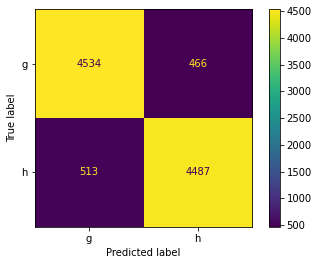

In [39]:
evaluate( model=neural_network_model_proc, test_dataloader=test_dataloader )

Model evaluation using raw data

In [41]:
test = Dataset(df_test_raw)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)

Tokenizing: 100%|██████████| 10000/10000 [00:55<00:00, 180.33it/s]


Evaluating: 100%|██████████| 10000/10000 [03:26<00:00, 48.50it/s]


              precision    recall  f1-score   support

           -       0.94      0.90      0.92      5000
           +       0.90      0.94      0.92      5000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



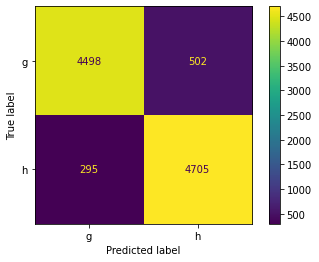

In [42]:
evaluate( model=neural_network_model_raw, test_dataloader=test_dataloader )